### Předpovědní model

In [964]:
from pathlib import Path

import pandas as pd
import numpy as np

# zpracování a vyhodnocení dat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error

# vizualizace
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pickle

# implementace Categorical Boostingu
from catboost import CatBoostRegressor

# optimalizační nástroj Optuna
import optuna

# knihovny pro práci s ML modely
from pycaret.regression import *
from autogluon.tabular import TabularPredictor

# pro práci s neoronovými sítěmi využijeme knihovnu pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

# implementace modelu Mamba
from mambapy.mamba import Mamba, MambaConfig


In [787]:
sns.set_style("darkgrid")

In [788]:
data_dir = Path('data')
stations = []

for parquet_file in data_dir.glob('*.pq'):
    stations.append(pd.read_parquet(parquet_file))

Data z jednotlivých stanic si uložíme do DataFramů, které pak budeme dále zpracovávat

In [789]:
stations_val_nr = {}

for station in stations:
    for column in station.columns:
        if column in stations_val_nr:
            stations_val_nr[column] += 1
        else:
            stations_val_nr[column] = 1

In [790]:
eliminate_columns = []
gfs_columns = []

for name, nr in stations_val_nr.items():
    if nr != len(stations):
        print(f'{name}: {nr}')
    if nr < 152:
        eliminate_columns.append(name)
    if nr == len(stations):
        gfs_columns.append(name)

air_temperature: 197
ground_temperature: 167
soil_temperature: 121
backup_sensor: 133
precipitation: 187
air_humidity: 191
leaf_wetness: 151
soil_humidity: 102
voltage: 211
soil_temperature_1: 33
soil_temperature_2: 36
soil_humidity_1: 31
soil_humidity_2: 31
water_level_cm: 2
battery_voltage: 3
GSM_signal: 1
air_temperature_30_cm: 6
air_temperature_60_cm: 4
air_temperature_90_cm: 4
air_temperature_120_cm: 4
air_temperature_150_cm: 6
light intensity_FAR: 4
soil_temperature_10_cm: 37
wind_direction_degrees: 50
wind_speed_m_per_sec: 55
soil_humidity_5_to_30_cm: 2
wind_speed_gust_10_sec: 31
soil_temperature_3: 15
soil_humidity_3: 20
soil_temperature_5_cm: 15
soil_temperature_30_cm: 4
soil_humidity_5_to_35_cm: 16
air_pressure: 5
leaf_wetness_trunk: 2
soil_humidity_60_cm: 2
leaf_wetness_edge: 2
leaf_wetness_treetop: 2
soil_humidity_30_cm: 5
soil_temperature_20_cm: 7
soil_humidity_20_to_50_cm: 1
soil_temperature_40_cm: 1
soil_humidity_5_to_25_cm: 1
air_temperature_180_cm: 3
air_temperature_1:

V přehledu je vidět zastoupení jednotlivých veličin (senzorů) napříč meteorologickými stanicemi. Vzhledem k výpočetní náročnosti si pro předpovědní model si vybereme příznaky *"air_temperature"*, *"ground_temperature"* a *"air_humidity"*. Tyto veličiny měří skoro všechny stanice a budou tedy vhodné pro relativní porovnání modelů.

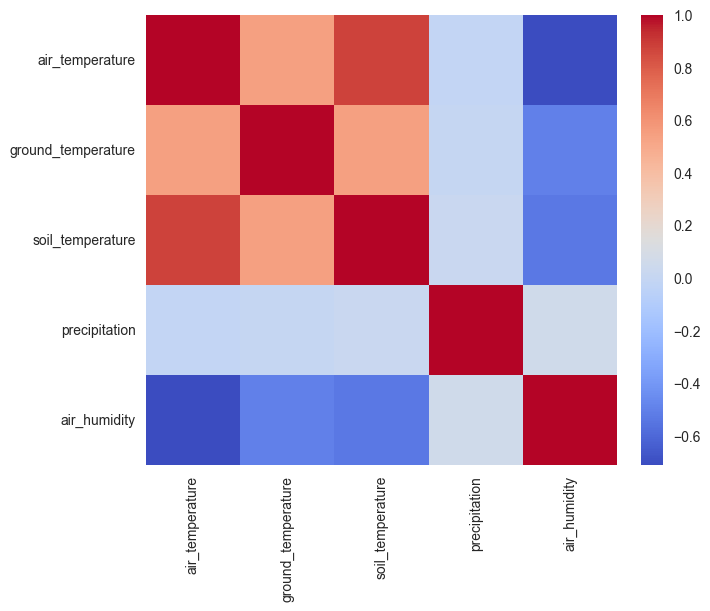

In [791]:
cols_for_corr = ['air_temperature', 'ground_temperature', 'soil_temperature', 'precipitation', 'air_humidity']
corr_matrix = stations[0][measured_cols].corr()

fig = plt.figure(figsize=(7, 6), constrained_layout=True)
ax1 = fig.add_subplot()

sns.heatmap(corr_matrix, cmap='coolwarm', ax=ax1)
plt.show()

Data obsahují mnoho pozitivně i negativně korelovaných hodnot.

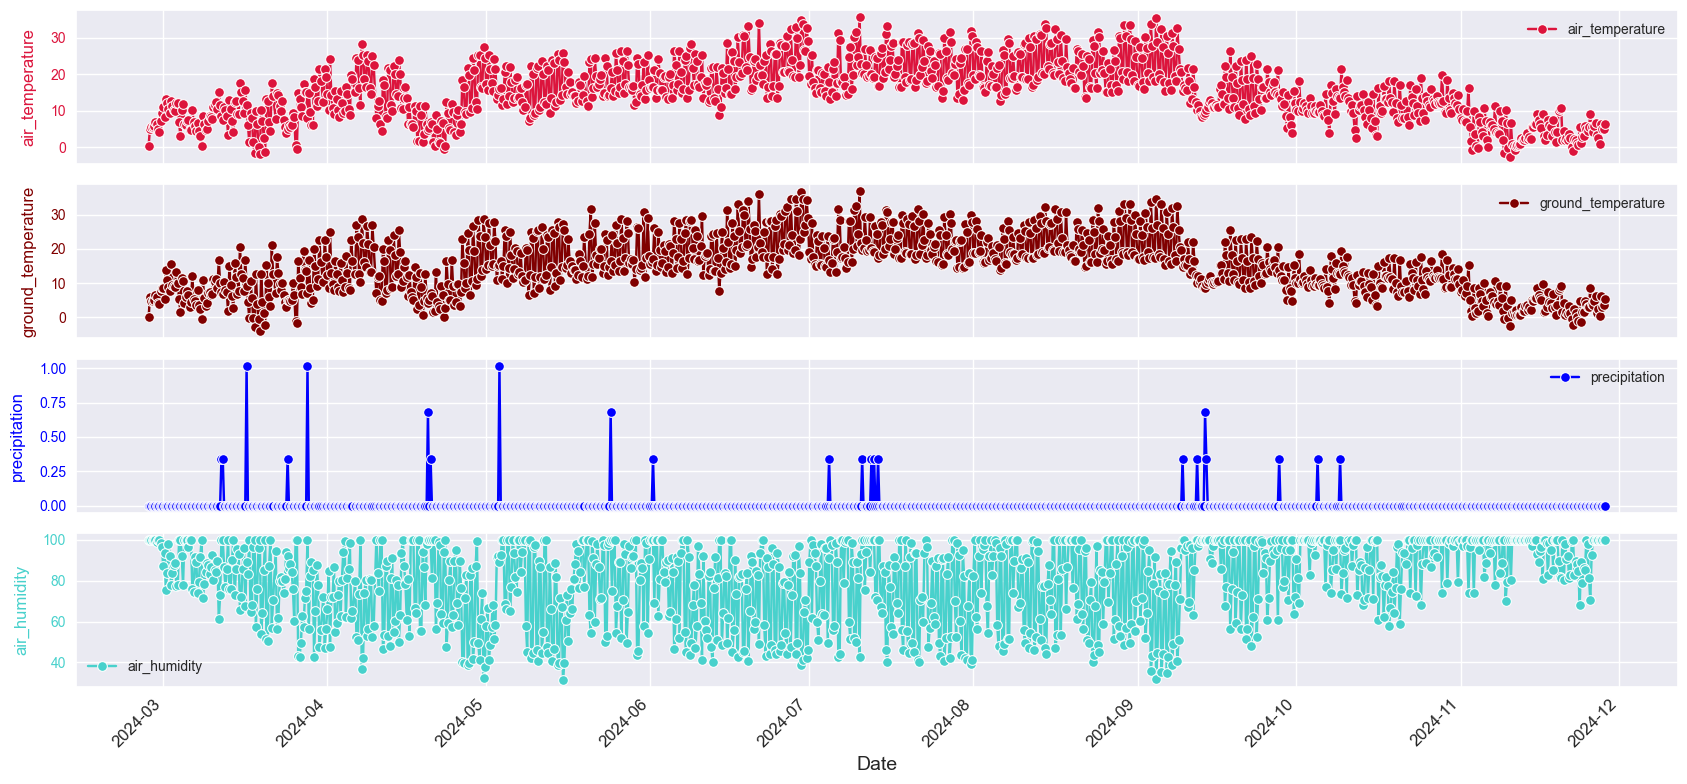

In [792]:
df = stations[8]

display_cols = ['air_temperature', 'ground_temperature', 'precipitation', 'air_humidity']
colors = ['crimson', 'maroon', 'blue', 'mediumturquoise']

fig, axes = plt.subplots(len(display_cols), 1, figsize=(17, 8), sharex=True)

if len(measured_cols) == 1:
    axes = [axes]

for idx, col in enumerate(display_cols):
    ax = axes[idx]
    sns.lineplot(x=df['datetime'], y=df[col], marker='o', color=colors[idx], ax=ax, label=col)    
    ax.set_ylabel(col, color=colors[idx], fontsize=12, labelpad=10)
    ax.tick_params(axis='y', labelcolor=colors[idx])

plt.xlabel('Date', fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')

plt.tight_layout()

plt.show()

Vizualizace dat ze stanice č. 9. Z grafu je zřejmé, že předpovídat srážky bude komplikované vzhledem k četným nulovým hodnotám. Z předpovědi jsem je tedy vyřadil.

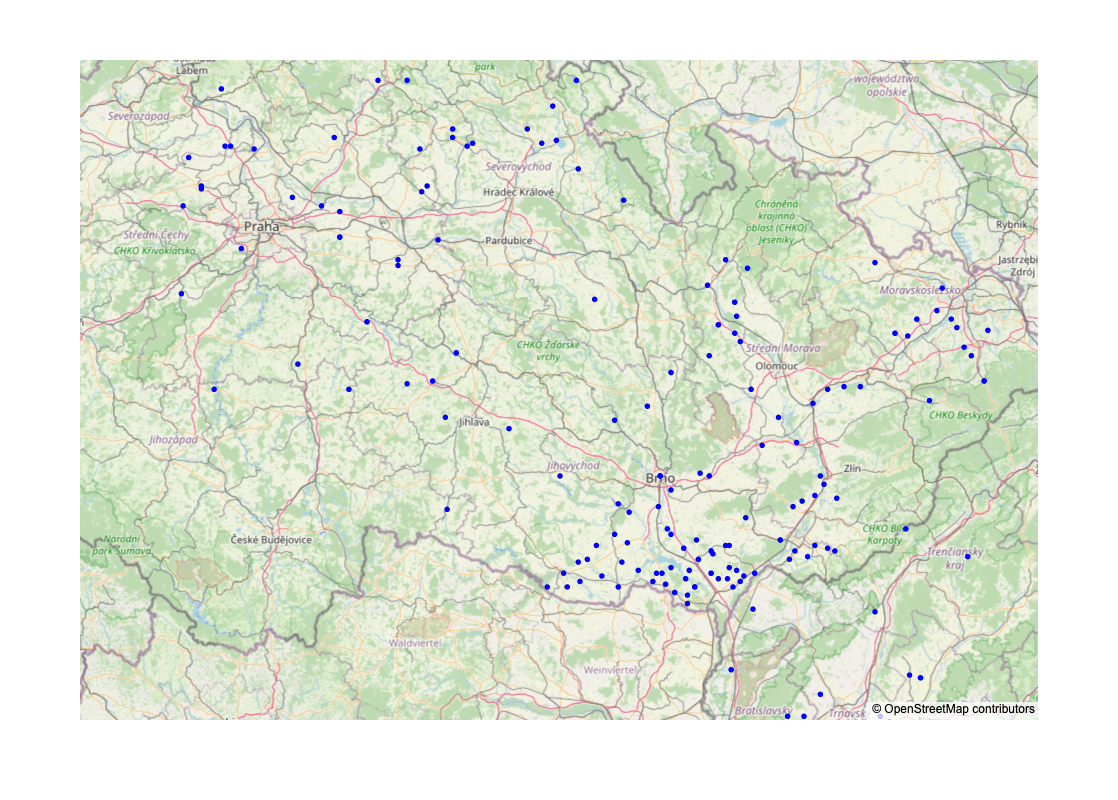

In [793]:
latitudes = []
longitudes = []

for _, station in enumerate(stations):
    latitudes.append(float(station['latitude'][0]))
    longitudes.append(float(station['longitude'][0]))

fig = px.scatter_mapbox(
    lat=latitudes, 
    lon=longitudes,
    zoom=6,
    width=1000, 
    height=800,
    color_discrete_sequence=['blue'],
    mapbox_style='open-street-map'
)

fig.show()

Vizualizace pozic meteorologických stanic. Nejvyšší koncentraci mají na jižní Moravě.

### Data preparation

In [794]:
print(f'Počet všech stanic: {len(stations)}')

Počet všech stanic: 213


Z dat nejdříve vyřadíme všechny sloupce, které neobsahují žádné hodnoty.

In [ ]:
for idx, station in enumerate(stations):
    missing_columns = station.columns[station.isna().all()]
    if not missing_columns.empty:
        print(f'Deleting columns in station {idx}: {missing_columns}')
        station.drop(missing_columns, axis=1, inplace=True)

Ve výpisu jsou vidět sloupce, které jsme odstranili. Abychom tedy měly GFS data pro všechny stanice stejné, sloupce **'voltage', 'surface_instant_sit', 'station_index', 'GSM_communication', 'solar_irradiance'** odstraníme ze všech stanic.

Vzhledem k faktu, že meteorologická data máme vždy po sešti hodinách, není vhodné chybějíci hodnoty doplňovat interpolací. Chybějící data a Nan data jsem tedy doplnil střední hodnotou. 

In [798]:
columns_to_drop = ['voltage', 'surface_instant_sit', 'station_index', 'GSM_communication', 'solar_irradiance']

for idx, station in enumerate(stations):
    station.drop(columns=[col for col in columns_to_drop if col in station.columns], axis=1, inplace=True)

    for col in station.columns:
        if pd.api.types.is_numeric_dtype(station[col]):
            median_value = station[col].median()
            station[col].fillna(median_value, inplace=True)

Protože některé stanice obsahují velmi málo relevantních dat, určil jsem rozhodující thresholdy které určí, zda-li danou stanici / příznak v datech ponecháme nebo ne. **MIN_SAMPLES_THRESHOLD** označuje minimální počet dat v pro stanici a **MIN_UNIQUE_SAMPLES_THRESHOLD** označuje minimální počet unikátních dat pro targetovanou promětou y. Tato omezení byla nutná, protože některé modely, např. PyCaret nebo Mamba, tato data neumí zpracovat.

In [931]:
### THRESHOLDS + SETTINGS

RANDOM_STATE = 33
MIN_SAMPLES_THRESHOLD = 50
MIN_SAMPLES_THRESHOLD_TS = 10
MIN_UNIQUE_SAMPLES_THRESHOLD = 20
MIN_UNIQUE_SAMPLES_THRESHOLD_TS = 2

### ONE STEP CONSTANTS

TIME_STEP_TO_HRS = 6
TIME_STEP = 4   ### time step is 24 hours

### TIME SERIES CONSTANTS

INPUT_SIZE = 4
OUTPUT_SIZE = 4 ### match for MAMBA

In [932]:
gfs_sub_vals = ['latitude', 'longitude', 'station_index', 'surface_instant_sit', 'datetime']

eliminate_columns.extend(['latitude', 'longitude', 'station_index', 'precipitation'])
gfs_columns = [item for item in gfs_columns if item not in gfs_sub_vals]

#### OneStep data

In [978]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f'Using device: {device}')

Using device: mps


V dalším kroku si připravíme množiny dat pro jednotlivé stanice. Data pro každou stanici jsou před rozdělením normalizována a pomocí **MinMax**. Pro každou stanici musíme vyfiltrovat potřebné veličiny, které budeme měrit a které jsou součástí GFS. Dále také musíme, mimo jiné, identifikovat chybějící měření a data případně vynechat, upravit. Pokud například nemáme dostatek dat v predikci pro časovou řadu, musíme data odstranit i pro jednokrokovou predikci, aby trénovací / vyhodnocovací data byla co nejvíce podobná. Nakonec si data agregujeme dle požadovaného formátu a uložíme do listu, který použijeme pro trénovaní / evaluaci stanic.

In [965]:
def one_step_data_prep(idx, entry, station, pred_df, measured_columns, gfs_columns):
    """
    If time difference is correct append selected data to pred_df
    """
    
    if idx < TIME_STEP:
        return pred_df

    ref_dt = entry['datetime'] - pd.Timedelta(hours=TIME_STEP * TIME_STEP_TO_HRS)
    past_dt = station['datetime'].iloc[idx - TIME_STEP]

    if ref_dt != past_dt:
        return pred_df

    curr_gfs_data = entry[gfs_columns]
    past_measured_data = station[measured_columns].iloc[idx - TIME_STEP]
    curr_measured_data = entry[measured_columns]

    row_data = pd.concat([curr_gfs_data, past_measured_data, curr_measured_data.rename(lambda x: f'target_{x}')])
    pred_df = pd.concat([pred_df, row_data.to_frame().T], ignore_index=True)
    return pred_df

In [966]:
def one_step_split_data(target_measured_columns, one_step_station_dict, one_step_tensor_station_dict, device, df):
    """
    For all targeted_columns, select them from a given df, that will be our target.
    Store the data both to normal and tensor datasets.
    """
    
    for column in target_measured_columns:
        y = df[column]
        X = df.drop(target_measured_columns, axis=1)
        
        ### skip prediction with low unique values -> PyCaret + MAMBA error
        if (len(y.unique()) < MIN_UNIQUE_SAMPLES_THRESHOLD):
            continue

        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
        one_step_station_dict[column] = (X_train, y_train, X_val, y_val)

        train_dataset = TensorDataset(
            torch.tensor(X_train.values.astype(np.float32), dtype=torch.float32, device=device),
            torch.tensor(y_train.values.astype(np.float32), dtype=torch.float32, device=device)
        )

        val_dataset = TensorDataset(
            torch.tensor(X_val.values.astype(np.float32), dtype=torch.float32, device=device),
            torch.tensor(y_val.values.astype(np.float32), dtype=torch.float32, device=device)
        )
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        one_step_tensor_station_dict[column] = (train_loader, val_loader, X.shape[1])

In [967]:
def ts_data_prep(idx, entry, station, ts_pred):
    """
    For given entry and idex, determine, wheter we have valid time-series.
    If so, slice the data and add it to our dataset
    """
    
    if idx < INPUT_SIZE or idx > (len(station) - OUTPUT_SIZE):
        return

    out_time = station['datetime'].iloc[idx + OUTPUT_SIZE - 1]
    in_time = station['datetime'].iloc[idx - INPUT_SIZE]
    delta_time = pd.Timedelta(hours=(INPUT_SIZE + OUTPUT_SIZE) * TIME_STEP_TO_HRS)

    if out_time - delta_time != in_time:
        return

    for column in iter(measured_columns):
        if column not in ts_pred:
            ts_pred[column] = np.array([])

        ins = station[column].iloc[idx - INPUT_SIZE:idx].values.astype(np.float32)
        outs = station[column].iloc[idx:idx + OUTPUT_SIZE].values.astype(np.float32)
        gfs = station[gfs_columns].iloc[idx + OUTPUT_SIZE - 1, :].values.astype(np.float32)
        data = np.concatenate([gfs, ins, outs], axis=0)

        if ts_pred[column].size == 0:
            ts_pred[column] = data
        else:
            ts_pred[column] = np.vstack([ts_pred[column], data])


In [968]:
def ts_split_data(ts_station_dict, ts_station_tensor_dict, device, df):
    """
    Split give datafrem into traning and validation sets.
    Store it to both normal and tensor datasets.
    """
    
    for key, val in df.items():
        gfs = val[:,:len(gfs_columns)]
        X = val[:,len(gfs_columns):len(gfs_columns)+INPUT_SIZE]
        y = val[:,len(gfs_columns)+INPUT_SIZE:]

        X_train, X_val, y_train, y_val, gfs_train, gfs_val = train_test_split(X, y, gfs, test_size=0.2, random_state=RANDOM_STATE)

        ### MAMBA issue -> scipy error
        if len(np.unique(y_train)) < MIN_UNIQUE_SAMPLES_THRESHOLD_TS or len(np.unique(X_train)) < MIN_UNIQUE_SAMPLES_THRESHOLD_TS:
            continue

        ts_station_dict[key] = (X_train, X_val, y_train, y_val, gfs_train, gfs_val)

        train_dataset = TensorDataset(
            torch.tensor(X_train, dtype=torch.float32, device=device),
            torch.tensor(y_train, dtype=torch.float32, device=device)
        )

        val_dataset = TensorDataset(
            torch.tensor(X_val, dtype=torch.float32, device=device),
            torch.tensor(y_val, dtype=torch.float32, device=device)
        )
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        ts_station_tensor_dict[key] = (train_loader, val_loader, X.shape[1], gfs_train, gfs_val)   

In [ ]:
"""For each station prepare prep and select data"""

time_series_data_windows = []
time_series_tensor_data_windows = []
one_step_stations_data = []
one_step_tensor_stations_data = []

for st_idx, station in enumerate(stations):
    if st_idx % 30 == 0:
        print(f'Processing station {st_idx}.')
    
    columns_to_drop = [col for col in eliminate_columns if col in station.columns]
    station = station.drop(columns_to_drop, axis=1)        
    station = station.reset_index(drop=True)

    measured_columns = [col for col in station.columns if col not in gfs_columns]
    measured_columns.remove('datetime')
    target_measured_columns = [f'target_{col}' for col in measured_columns]

    date_time = station.pop('datetime')    
    scaler = MinMaxScaler(feature_range=(0, 1))
    ### Normalize using MinMax
    station = pd.DataFrame(
        scaler.fit_transform(station),  
        columns=station.columns
    )
    station['datetime'] = date_time
    
    pred_df = pd.DataFrame(columns=gfs_columns + measured_columns + target_measured_columns)
    ts_pred = {}
    
    for idx, entry in station.iterrows():
        pred_df = one_step_data_prep(idx, entry, station, pred_df, measured_columns, gfs_columns)
        ts_data_prep(idx, entry, station, ts_pred)

    if len(pred_df) < MIN_SAMPLES_THRESHOLD:
        print(f'Erasing station: {st_idx}. Not enough data.')
        continue

    one_step_station_dict = {}
    one_step_tensor_station_dict = {}
    ts_station_dict = {}
    ts_station_tensor_dict = {}

    one_step_split_data(target_measured_columns, one_step_station_dict, one_step_tensor_station_dict, device, pred_df)
    ts_split_data(ts_station_dict, ts_station_tensor_dict, device, ts_pred)

    if len(one_step_station_dict) == 0 or len(ts_station_dict) == 0:
        print(f'Erasing station: {st_idx}. Not enough data.')
        continue
    
    one_step_stations_data.append(one_step_station_dict)
    one_step_tensor_stations_data.append(one_step_tensor_station_dict)
    time_series_data_windows.append(ts_station_dict)
    time_series_tensor_data_windows.append(ts_station_tensor_dict)

Validační skóre si budeme ukládat do slovníku. Modely budeme trénovat vůči **RMSE**, na validačních množínách si ale spočítáme i **MSE** i **MAE**

In [ ]:
def append_validation_results(val_loss_dict, model_name, rmse_dict, mse_dict, mae_dict):
    new_dict = {
        "RMSE": rmse_dict,
        "MSE": mse_dict,
        "MAE": mae_dict
    }
    
    val_loss_dict[model_name] = new_dict

In [595]:
#val_loss_dict = {}

Pro zpracování stanic si připravíme dekorátory, které nám zjednoduší práci s ukldáním metrik a iterováním přes stanice a veličiny.

In [853]:
def process_stations(func):
    """
    Decorator for printing and storage of validation metrics
    """
    def wrapper(one_step_stations_data, *args, **kwargs):
        rmse_qty_loss_summary = {}
        mse_qty_loss_summary = {}
        mae_qty_loss_summary = {}

        print(f'Validation MSE fore each model:')
        for idx, station_data in enumerate(one_step_stations_data):
            print(f'---- station {idx + 1} ----')
            
            for key, val in station_data.items():
                rmse_score, mse_score, mae_score = func(key, val, *args, **kwargs)
                print(f'{key}: {mse_score:0.3f}')

                if key in rmse_qty_loss_summary:
                    rmse_qty_loss_summary[key].append(rmse_score)
                    mse_qty_loss_summary[key].append(mse_score)
                    mae_qty_loss_summary[key].append(mae_score)
                else:
                    rmse_qty_loss_summary[key] = [rmse_score]
                    mse_qty_loss_summary[key] = [mse_score]
                    mae_qty_loss_summary[key] = [mae_score]
                
        return rmse_qty_loss_summary, mse_qty_loss_summary, mae_qty_loss_summary
    return wrapper

In [852]:
def print_statistics(func):
    """
    Iterate through each station and each quantity and print validation metrics
    """
    def wrapper(*args, **kwargs):
        losses = func(*args, **kwargs)

        total_loss = []
        print(50 * '-')
        for key, val in losses[1].items():
            total_loss.append(val)
            print(f'Average MSE of {key}: {np.array(val).mean():0.4f}')

        total_loss = np.concatenate(total_loss)
        
        print(50 * '-')
        print(f'Total MSE val loss: {total_loss.sum():0.4f}')
        print(f'Average MSE val loss: {total_loss.mean():0.4f}')
        print(f'Median MSE val loss: {np.median(total_loss):0.4f}')

        return losses
    return wrapper

A nyní postupně natrénujeme všechny modely. Začneme nejdříve **jednokorokovou predikcí** - tedy jednoduchá regresní úloha. Natrénujeme modely **CatBoost + Optuna** (optimalizace),**AutoGluon**, **PyCaret** a **Preceptronové neuronové sítě**. Poté vyzkoušíme predikci pomocí **časové řady**, konkrétně modely **LSTM** a **Mamba**. Nakonec vyzkoušíme ensamble modely. Nejdříve natrénujeme model pro predikci časové řady a poté zkusíme tuto predikci upřesnit pomocí regresního modelu. Vyzkoušíme kombinaci **LSTM + CatBoost**.

### Jednokroková predikce - oddělené stanice

#### 1) CatBoost + Optuna

In [1401]:
def objective(trial, X_train, y_train, X_val, y_val):
    """
    Objective function for optuna optimizer
    """
    params = {
        'iterations': trial.suggest_int('iterations', 500, 1500),
        'depth': trial.suggest_int('depth', 3, 10),
        'loss_function': 'RMSE',
    }

    train_pool = Pool(X_train, y_train)
    val_pool = Pool(X_val, y_val)

    model = CatBoostRegressor(**params, verbose=0)
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, verbose=False)

    y_pred = model.predict(X_val)
    return mean_squared_error(y_val, y_pred, squared=True)

In [1402]:
@print_statistics
@process_stations
def cat_boost_optuna_train(column, station_data):
    """
    Trian cat_boost based on station_data using the Optuna optimizer. 
    """
    X_train, y_train, X_val, y_val = station_data

    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val), n_trials=2)

    best_params = study.best_params

    model = CatBoostRegressor(**best_params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=0, early_stopping_rounds=50)

    y_pred = model.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    
    return rmse, mse, mae

In [ ]:
append_validation_results(val_loss_dict, "cat_boost", *cat_boost_optuna_train(one_step_stations_data))

#### 2) AutoGluon

In [1403]:
@print_statistics
@process_stations
def tabulator_predictor_train(column, station_data):
    """
    Train AutoGluon TabulatorPredictor based on station_data.
    """
    
    X_train, y_train, X_val, y_val = station_data
        
    train_data = X_train.copy()
    train_data[column] = y_train
    
    val_data = X_val.copy()
    val_data[column] = y_val

    predictor = TabularPredictor(label=column).fit(
        train_data=train_data,
        time_limit=20,
        presets='best',
        verbosity=1
    )
    
    y_pred = predictor.predict(X_val)
    
    rmse = root_mean_squared_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    
    return rmse, mse, mae

In [ ]:
append_validation_results(val_loss_dict, "autogluon", *tabulator_predictor_train(one_step_stations_data))

#### 3) PyCaret

In [1404]:
@print_statistics
@process_stations
def pycaret_train(column, station_data):
    """
    Train PyCaret model based on station_data.
    """
    
    X_train, y_train, X_val, y_val = station_data
        
    train_data = X_train.copy()
    train_data[column] = y_train
    
    val_data = X_val.copy()
    val_data[column] = y_val
        
    reg1 = setup(data = train_data, test_data=val_data, target = column, session_id=RANDOM_STATE, fold=2,
        normalize = True, transformation = True, transform_target = True, 
        categorical_features=[],
        remove_multicollinearity = True,
        verbose=False )

    best_model = compare_models(sort = 'RMSE')
    tuned_model = tune_model(best_model, n_iter=2, optimize='RMSE')
    tuned_metrics_table = pull()
    rmse = tuned_metrics_table['RMSE']['Mean']
    mse = tuned_metrics_table['MSE']['Mean']
    mae = tuned_metrics_table['MAE']['Mean']

    return rmse, mse, mae

In [ ]:
append_validation_results(val_loss_dict, "pycaret", *pycaret_train(one_step_stations_data))

#### 4) MLP

In [1405]:
def train_one_epoch(model, device, train_loader, optimizer, criterion):
    """
    Train one epoch of model using train_loader pytorch tensor.
    """
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = torch.sqrt(criterion(output, target))
        loss.backward()
        optimizer.step()

In [1406]:
@print_statistics
@process_stations
def train_mlp(column, station_data, device, num_epochs=200, learning_rate = 1e-3):  
    """
    Train simple mlp based on station_data, iterate up to num_epochs.
    """
    
    train_loader, test_loader, shape = station_data
        
    model = MLP(shape).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(1, num_epochs):
        train_one_epoch(model, device, train_loader, optimizer, criterion)
        
    model.eval()
    rmse = 0
    mse = 0
    mae = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            y_val = target.cpu()
            y_pred = output.cpu()
            rmse += root_mean_squared_error(y_val, y_pred)
            mse += mean_squared_error(y_val, y_pred)
            mae += mean_absolute_error(y_val, y_pred)

    return rmse, mse, mae

In [1410]:
class MLP(nn.Module):
    """
    Simple MLP nn.
    """
    
    def __init__(self, input_size):
        """
        Initialize nn based on input_size
        """
        
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 4)
        self.fc3 = nn.Linear(4, 2)
        self.fc4 = nn.Linear(2, 1)
    
    def forward(self, x):
        """
        Calculate forward of MLP.
        """
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
device = torch.device('mps')
append_validation_results(val_loss_dict, "mlp", *train_mlp(one_step_tensor_stations_data, device))

### Predikce časové řady

#### 1) LSTM

In [1411]:
class LSTMNet(nn.Module):
    """
    Recurent nn LSTM.
    """
    
    def __init__(self, input_dim):
        """
        Initialize nn based on input_dim.
        """
        
        super(LSTMNet, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_dim, hidden_size=64, num_layers=5, batch_first=True) 
        self.fco = nn.Linear(64, 4)
    
    def forward(self, x):
        """
        Calculate forward of nn.
        """
        
        lstm_out, _ = self.lstm1(x)
        lstm_out = lstm_out.unsqueeze(1)
        x = lstm_out[:, -1, :] 
        x = self.fco(x)
        return x

In [1412]:
@print_statistics
@process_stations
def train_lstm(key, station_data, device, num_epochs=100, learning_rate = 1e-3):
    """
    Train LSTM nn based on station_data.
    """
    train_loader, test_loader, input_dim = station_data
        
    model = LSTMNet(input_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
        
    for epoch in range(1, num_epochs):
        train_one_epoch(model, device, train_loader, optimizer, criterion)
        
    model.eval()
    rmse = 0
    mse = 0
    mae = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            y_val = target.cpu()
            y_pred = output.cpu()
            rmse += root_mean_squared_error(y_pred[:,OUTPUT_SIZE - 1], y_val[:,OUTPUT_SIZE - 1])
            mse += mean_squared_error(y_pred[:,OUTPUT_SIZE - 1], y_val[:,OUTPUT_SIZE - 1])
            mae += mean_absolute_error(y_pred[:,OUTPUT_SIZE - 1], y_val[:,OUTPUT_SIZE - 1])
    return rmse, mse, mae

In [ ]:
device = torch.device("mps")
append_validation_results(val_loss_dict, "lstm", *train_lstm(time_series_tensor_data_windows, device))

#### 2) MAMBA

In [1413]:
def train_one_epoch_mamba(model, device, train_loader, optimizer, criterion):
    """
    Train one epoch of Mamba model using train_loader.
    """
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data.unsqueeze(-1))

        if torch.isnan(output).any():
            continue
        
        loss = torch.sqrt(criterion(output.squeeze(), target))
        loss.backward()
        optimizer.step()

In [1414]:
@print_statistics
@process_stations
def train_mamba(key, station_data, device, num_epochs=100, learning_rate = 1e-3):
    """
    Train Mamba model based on station_data.
    """
    
    train_loader, test_loader, input_dim = station_data
    
    config = MambaConfig(d_model=1, n_layers=4)
    model = Mamba(config).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
        
    for epoch in range(1, num_epochs):
        train_one_epoch_mamba(model, device, train_loader, optimizer, criterion)
        
    model.eval()
    rmse = 0
    mse = 0
    mae = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            output = model(data.unsqueeze(-1))

            if torch.isnan(output).any():
                continue
            
            y_val = target.to(device)
            y_pred = output.to(device)
            rmse += root_mean_squared_error(y_pred[:,OUTPUT_SIZE - 1], y_val[:,OUTPUT_SIZE - 1])
            mse += mean_squared_error(y_pred[:,OUTPUT_SIZE - 1], y_val[:,OUTPUT_SIZE - 1])
            mae += mean_absolute_error(y_pred[:,OUTPUT_SIZE - 1], y_val[:,OUTPUT_SIZE - 1])
    return rmse, mse, mae

In [ ]:
device = torch.device("cpu")    ### library doesn't support MPS
append_validation_results(val_loss_dict, "mamba", *train_mamba(time_series_tensor_data_windows, device))

### Ensemble Model

#### LSTM + Mamba ensemble

In [1415]:
@print_statistics
@process_stations
def train_lstm_catboost_ensemble(key, station_data, device, num_epochs=400, learning_rate=1e-3):
    """
    Train ensemble model LSTM + CatBoost based on station_data.
    """
    
    train_loader, val_loader, input_size, gfs_train, gfs_val = station_data

    lstm_model = LSTMNet(input_size).to(device)
    optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    for epoch in range(1, num_epochs):
        train_one_epoch(lstm_model, device, train_loader, optimizer, criterion)

    lstm_model.eval()
    train_outputs = []
    train_labels = []

    with torch.no_grad():
        for data, target in train_loader:
            outputs = lstm_model(data)
            train_outputs.append(outputs.cpu().numpy())
            train_labels.append(target.cpu().numpy())

    val_outputs = []
    val_labels = []

    with torch.no_grad():
        for data, target in val_loader:
            outputs = lstm_model(data)
            val_outputs.append(outputs.cpu().numpy())
            val_labels.append(target.cpu().numpy())

    train_outputs = np.concatenate(train_outputs, axis=0)
    y_train = np.concatenate(train_labels, axis=0)

    val_outputs = np.concatenate(val_outputs, axis=0)
    y_val = np.concatenate(val_labels, axis=0)

    X_train = np.column_stack((train_outputs[:, OUTPUT_SIZE - 1], gfs_train))
    y_train = y_train[:, OUTPUT_SIZE - 1]

    X_val = np.column_stack((val_outputs[:, OUTPUT_SIZE - 1], gfs_val))
    y_val = y_val[:, OUTPUT_SIZE - 1]

    # ### catboost error
    # if len(np.unique(y_train)) < 2:
    #     continue

    train_pool = Pool(X_train, y_train)
    val_pool = Pool(X_val, y_val)

    catboost_model = CatBoostRegressor(iterations=1500, depth=7, loss_function='RMSE', verbose=0)
    catboost_model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, verbose=False)

    y_pred = catboost_model.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)

    return rmse, mse, mae

In [ ]:
device = torch.device("mps")
append_validation_results(val_loss_dict, "lstm_catboost", *train_lstm_catboost_ensemble(time_series_tensor_data_windows, device))

#### GFS reference

In [1416]:
@print_statistics
@process_stations
def test_gfs_acc(column, station_data):
    """
    Calculate accuracy of GFS model based on station_data.
    """
    
    X_train, y_train, X_val, y_val = station_data
    rmse = 0
    mse = 0
    mae = 0
    if column == 'target_air_temperature' or column == 'target_ground_temperature':
        y_pred = X_val['surface_instant_t']
        rmse = root_mean_squared_error(y_val, y_pred)
        mse = mean_squared_error(y_val, y_pred)
        mae = mean_absolute_error(y_val, y_pred)
    elif column == 'target_air_humidity':
        y_pred = X_val['pressureFromGroundLayer_instant_r']
        rmse = root_mean_squared_error(y_val, y_pred)
        mse = mean_squared_error(y_val, y_pred)
        mae = mean_absolute_error(y_val, y_pred)

    return rmse, mse, mae

In [ ]:
append_validation_results(val_loss_dict, "gfs", *test_gfs_acc(one_step_stations_data))

In [1361]:
copy_val_loss_dict = val_loss_dict.copy()

### Výsledky

Nakonec vytvoříme vizualizaci výsledků. Zobrazíme průměrné ztráty pro různé metriky a průměrné ztráty pro jednotlivé předpovídané veličny. 

In [1362]:
ignore_models = ['pycaret', 'mlp']

In [1417]:
def calc_average_losses(metric):
    """
    Calculate average loss for each model and for each quantity. 
    """
    
    average_losses = {}
    average_losses_by_cat = {}
    
    for model, val in copy_val_loss_dict.items():
        q_dict = val[metric]
        all_losses = []
        cat_losses = {}
        
        for q_key, q_val in q_dict.items():
            cat_losses[q_key] = np.array(q_val).mean()
            all_losses.extend(q_val)
        
        average_losses[model] = np.array(all_losses).mean()
        average_losses_by_cat[model] = cat_losses

    categories = {}
    
    for model, values in average_losses_by_cat.items():
        for category, loss in values.items():
            if category.startswith("target_"):
                variable = category[len("target_"):]
                merged_category = variable
            else:
                merged_category = category
            
            if merged_category not in categories:
                categories[merged_category] = {}
            categories[merged_category][model] = loss

    return average_losses, categories

In [1418]:
def plot_losses(categories, scheme, gfs_color=(1.0, 0.0, 0.0)):
    """
    Create plots for each category in categories.
    """
    
    fig, axes = plt.subplots(1, len(categories), figsize=(14, 5))
    
    if len(categories) == 1:
        axes = [axes]
    
    for i, (category, data) in enumerate(categories.items()):
        sorted_data = sorted(data.items(), key=lambda x: x[1])
        models, values = zip(*sorted_data)

        models, values = zip(*[(model, value) for model, value in zip(models, values) if model not in ignore_models])

        base_palette = sns.color_palette(scheme, n_colors=len(models))
        custom_palette = [gfs_color if model == 'gfs' else base_palette[j] for j, model in enumerate(models)]
        
        sns.barplot(x=models, 
                    y=values, 
                    ax=axes[i], 
                    palette=custom_palette,
                    edgecolor='black', 
                    linewidth=0.5)
        
        axes[i].set_title(f"{category}", fontsize=12)
        axes[i].set_ylabel(f"{category}", fontsize=10)
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()


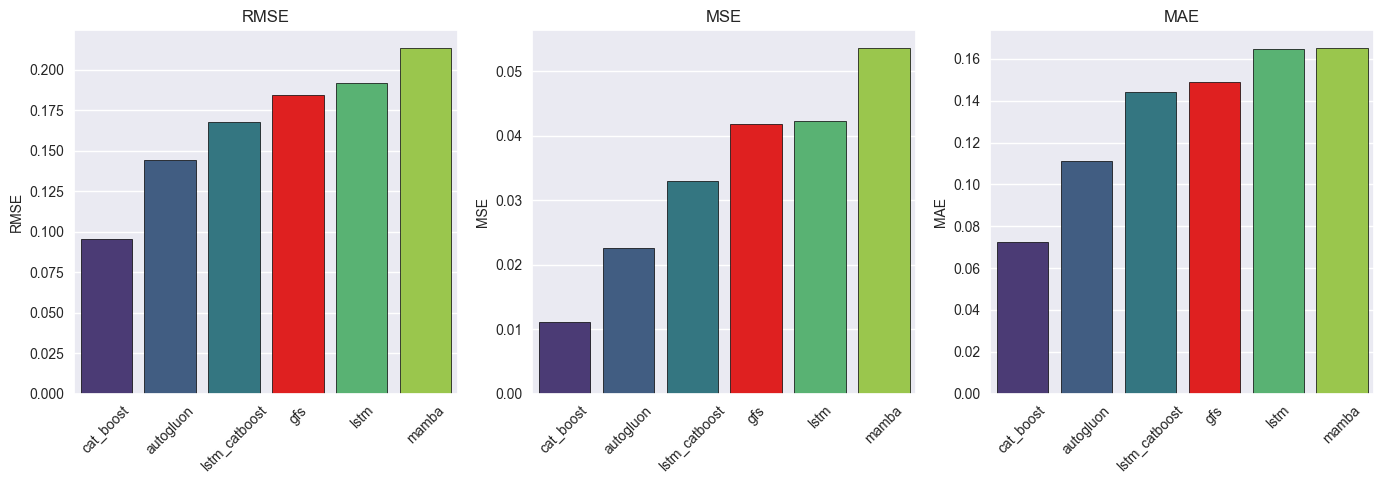

In [1398]:
average_losses = {loss: calc_average_losses(loss)[0] for loss in ['RMSE', 'MSE', 'MAE']}
plot_losses(average_losses, 'viridis')

Vizualizace průměrné ztrátovosti modelů napříč všemi veličinami pro různé metriky.

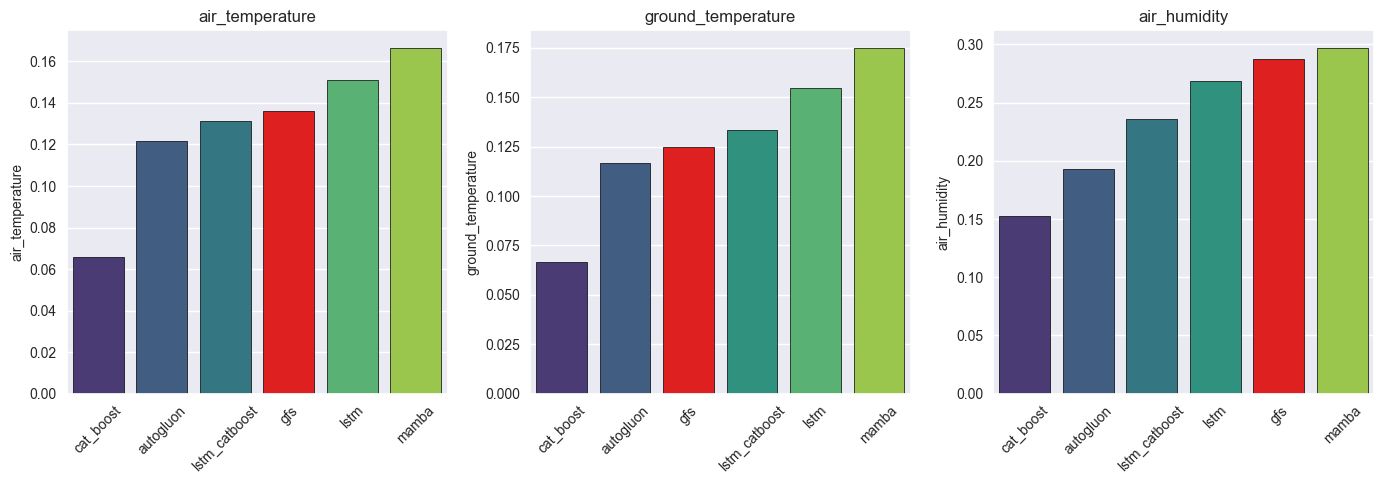

In [1399]:
cat_losses = calc_average_losses('RMSE')[1]
plot_losses(cat_losses, 'viridis')

Vizualizace ztrátovosti pro jednotlivé veličiny v RMSE.

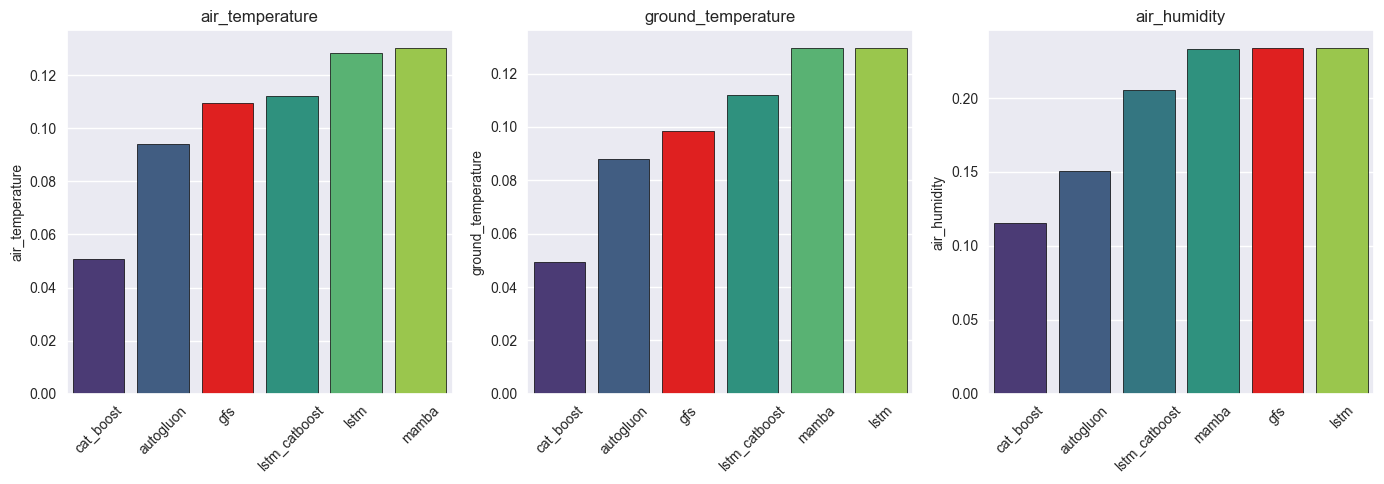

In [1400]:
cat_losses = calc_average_losses('MAE')[1]
plot_losses(cat_losses, 'viridis')

Vizualizace ztrátovosti pro jednotlivé veličiny v MAE.

Z výsledků je zřejmé, že **CatBoost je nejpřesnější model ze všech**. Jeho předpověď je konzistetně přesnější než gfs jak v průměru, tak i pro všechny veličny. **Druhý nejpřesnější model je autogluon**, který je rovněž v průměru přesnější pro všechny veličny. **Třetí nejpřesnější model je ensemble LSTM a Catboost**, který je ale v průměru méně přešný v predikci přízemní teploty než gfs. Z vyzualizace jsem odebral modely MLP a PyCaret, v omezených podmínkách se mi je nepodařilo dostatečně natrénovat a jejich průěrná validační ztráta je výrazně vyšší než všechny ostatní modely.

### Sample data pro vizualizační aplikaci

Dále si také připravíme data, která využijeme pro demonstraci vizualizační aplikace v Dashi. </br>
Obecně aplikace přijímá meteorologická data ve formátu trojrozměrné matice: **np.array[ čas, staince, veličina ]**</br>
a data o pozici stanic: **pd.DataFrame[ zeměpisná šířka , zeměpisná výška ]**

In [707]:
VIS_RANGE = 11
start_time = pd.Timestamp('2024-09-06 00:00:00')
quantities = ['air_temperature', 'ground_temperature', 'air_humidity', 'precipitation']

In [1420]:
def prep_station(idx, station, matrix, start_time, stations_loc):
    """
    Prepare station data for vizualization.
    """
    
    station = station.reset_index(drop=True)
    index = station.loc[station['datetime'] == start_time].index
    
    if index.empty:
        print(f'Skipping station {idx}, time slice not found.')
        return matrix

    index = index[0]
    
    calc_dt = station['datetime'].iloc[index + VIS_RANGE] - pd.Timedelta(hours = VIS_RANGE * TIME_STEP_TO_HRS)
    start_dt = station['datetime'].iloc[index]

    if calc_dt != start_dt:
        print(f'Skipping station {idx}, insufficient data.')
        return matrix
    
    for quantitiy in quantities:
        if quantitiy not in station.columns:
            print(f'Skipping station {idx}, missing {quantitiy}.')
            return matrix

    station_data = station.iloc[index:index + VIS_RANGE][quantities].to_numpy()
    if matrix.size == 0:
        matrix = np.zeros((VIS_RANGE, 0, len(quantities)), dtype=np.float32)
    matrix = np.append(matrix, station_data[:, np.newaxis, :], axis=1)


    stations_loc['lat'].append(station['latitude'].iloc[0]) 
    stations_loc['lon'].append(station['longitude'].iloc[0]) 

    return matrix

In [ ]:
stations_loc = {
    'lon': [],
    'lat': []
}

data_matrix = np.array([], dtype=np.float32)
for idx, station in enumerate(stations):
    data_matrix = prep_station(idx, station, data_matrix, start_time, stations_loc)

In [763]:
stations_loc_df = pd.DataFrame(stations_loc)

A nakonec data uložíme.

In [764]:
stations_loc_df.to_csv('data.csv', index=False)
np.save('matrix.npy', data_matrix)